In [1]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split


from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

from tensorflow.keras.utils import Sequence, to_categorical
from keras.models import load_model
import math
import cv2

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score, f1_score
)

2024-08-12 20:38:42.675263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 20:38:42.807434: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 20:38:43.347690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-08-12 20:38:43.347773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [2]:
inter_path = os.path.abspath("/data/inter")

used_labels = {"NORMAL": 0, "DRUSEN": 1, "DME": 2, "CNV": 3}


class OCTSequence(Sequence):
    def __init__(self, dataframe, batch_size=16, augmentate=False, inputshape=(224, 224,3), preprocessing_fcn=None):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.augmentate = augmentate
        self.inputshape = inputshape
        self.preprocessing_fcn = preprocessing_fcn

    def __len__(self):
        return math.ceil(len(self.dataframe) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.dataframe.iloc[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]["file_path"].values
        # batch_y = 1.0*(np.maximum(self.dataframe.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]['redsmalldots'].values,
        #            self.dataframe.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]['hemorrhages'].values)>0.75)
        batch_y = self.dataframe.iloc[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]["label"].values
        batch_y = to_categorical(
            [used_labels[i] for i in batch_y], num_classes=len(used_labels.keys())
        )

        return np.array(
            [self.preprocess(cv2.imread(file_name)) for file_name in batch_x]
        ), np.array(batch_y)

    def preprocess(self, image):
        if self.augmentate:
            rotation_angle = np.random.randint(low=-15, high=15)
            
            rotmat = cv2.getRotationMatrix2D(
                (image.shape[1] // 2, image.shape[0] // 2), rotation_angle, 1
            )
            

            image = cv2.warpAffine(
                src=image,
                M=rotmat,
                dsize=(image.shape[1], image.shape[0]),
                borderMode=cv2.BORDER_REFLECT,
            )

            # flips
            if np.random.randint(low=0, high=2):
                image = np.fliplr(image)
            if np.random.randint(low=0, high=2):
                image = np.flipud(image)

            #cropping
            center = np.array(image.shape) / 2
            xc = int(center[1] - image.shape[1]/2)
            yc = int(center[0] - image.shape[0]/2)
            x = image[yc:yc+int(0.7*image.shape[0]), xc:xc+int(0.7*image.shape[1])]   
            x = cv2.resize(x, self.inputshape[:-1])

            
            #x = cv2.resize(image, self.inputshape[:-1])
            '''
            alfa = 4.0
            tal = -4.0
            xf = cv2.GaussianBlur(x, ksize=(0, 0), sigmaX=x.shape[0] // 30, sigmaY=0)
            xf = xf.astype(np.float32)
            x = x.astype(np.float32)
            x = alfa * x + tal * xf + 128.0
            x[x < 0] = 0
            x[x > 255] = 255
            x = x.astype(np.float32)
            '''
        else:
            #cropping
            center = np.array(image.shape) / 2
            xc = int(center[1] - image.shape[1]/2)
            yc = int(center[0] - image.shape[0]/2)
            x = image[yc:yc+int(0.7*image.shape[0]), xc:xc+int(0.7*image.shape[1])]   
            x = cv2.resize(x, self.inputshape[:-1])
        
        if self.preprocessing_fcn is None:
            x -= 127.0
            x /= 127.0
        else:
            x = x.astype(np.uint8)
            x = self.preprocessing_fcn(x)

        return x

    def on_epoch_end(self):
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)


In [5]:
# load the train dataset
train_data_path = os.path.abspath("/data/ZhangLabData/CellData/OCT/train") # /data/ZhangLabData/CellData/OCTtrain
filelist_train = []

for root, dirs, files in os.walk(train_data_path):
        for file in files:
            # append the file name to the list
            filelist_train.append(os.path.join(root, file))
diseases = [i.split("-")[0].split("/")[-1] for i in filelist_train]
patient = [i.split("-")[1] for i in filelist_train]
image_nb = [i.split("-")[-1] for i in filelist_train]

df_train = pd.DataFrame(
        data={
            "label": diseases,
            "patient": patient,
            "image_nb": image_nb,
            "file_path": filelist_train,
        }
    )

print("DADOS DESBALANCEADOS")
print("\n found {} training images...".format(len(df_train)))

#split the training and validation datasets
train_val_split_mode = "patient"
train_val_split_rate = 0.2

if train_val_split_mode == "patient":
        # Get unique patient IDs
        patient_ids = df_train["patient"].unique()
        # Split patient IDs into training and validation sets
        train_ids, val_ids = train_test_split(patient_ids, test_size=train_val_split_rate, random_state=42)

        # Create training and validation dataframes based on patient IDs
        df_new_train = df_train[df_train["patient"].isin(train_ids)]
        df_val = df_train[df_train["patient"].isin(val_ids)]
        df_train = df_new_train


# print the number of images in df_train for each class
print("\n training set:")
print(df_train["label"].value_counts())

# print the number of images in df_val for each class
print("\n validation set:")
print(df_val["label"].value_counts())

# load the test dataset
test_data_path = os.path.abspath("/data/ZhangLabData/CellData/OCT/test")
filelist_test = []

for root, dirs, files in os.walk(test_data_path):
        for file in files:
            # append the file name to the list
            filelist_test.append(os.path.join(root, file))
diseases = [i.split("/")[-2] for i in filelist_test]
patient = [i.split("-")[-2] for i in filelist_test]
image_nb = [i.split("-")[-1] for i in filelist_test]

df_test = pd.DataFrame(
        data={
            "label": diseases,
            "patient": patient,
            "image_nb": image_nb,
            "file_path": filelist_test,
        }
    )
print("\n found {} test images...\n".format(len(df_test)))
# print the number of images in df_test for each class
print("\n test set:")
print(df_test["label"].value_counts())
print()

DADOS DESBALANCEADOS

 found 108309 training images...

 training set:
label
NORMAL    41023
CNV       28514
DME        9398
DRUSEN     6673
Name: count, dtype: int64

 validation set:
label
NORMAL    10117
CNV        8691
DME        1950
DRUSEN     1943
Name: count, dtype: int64

 found 1000 test images...


 test set:
label
CNV       250
DME       250
DRUSEN    250
NORMAL    250
Name: count, dtype: int64



In [6]:
#NÚMERO DE IMAGENS EM CADA CONJUNTO
print('Training set has {} images from {} patients'.format(len(df_train),df_train.patient.nunique()))
print('Validation set has {} images from {} patients'.format(len(df_val),df_val.patient.nunique()))
print('Test set has {} images from {} patients'.format(len(df_test),df_test.patient.nunique()))
print()

#CASOS DE VAZAMENTO DE DADOS
print('There are {} patients that are both in training and test sets.'.format(len(set(df_train.patient) & set(df_test.patient))))
print('There are {} patients that are both in training and validation sets.'.format(len(set(df_train.patient) & set(df_val.patient)))) 
print('There are {} patients that are both in validation and test sets.'.format(len(set(df_test.patient) & set(df_val.patient))))
print('There are {} patients that are both in validation test and train sets.'.format(len(set(df_test.patient) & set(df_val.patient) & set(df_train.patient))))
print()

Training set has 85608 images from 3828 patients
Validation set has 22701 images from 957 patients
Test set has 1000 images from 635 patients

There are 0 patients that are both in training and test sets.
There are 0 patients that are both in training and validation sets.
There are 0 patients that are both in validation and test sets.
There are 0 patients that are both in validation test and train sets.



In [17]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #base_model.load_weights("/data/models/mobilenet_v2_weights.h5")
preprocessing_fcn = tf.keras.applications.mobilenet_v2.preprocess_input

# Create a new model
model = Sequential()
# Add the pre-trained model to the new model
model.add(base_model)
# Add a flatten layer to the new model
model.add(Flatten())
# Add a dense layer with 4 outputs to the new model
model.add(Dense(4, activation="softmax"))
input_shape = model.layers[0].input_shape[1:]

        
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #         loss=tf.keras.losses.KLDivergence(reduction="auto", name="kl_divergence"),
    #          metrics=[tf.keras.metrics.CategoricalAccuracy("accuracy"),
    #                   tf.keras.metrics.AUC(name="auc")])


df_val = df_val.sample(frac=1).reset_index(drop=True)
val_seq = OCTSequence(
    df_val,
    batch_size=16,
    augmentate=False,
    inputshape=input_shape,
    preprocessing_fcn=preprocessing_fcn,
)

df_train = df_train.sample(frac=1).reset_index(drop=True)
train_seq = OCTSequence(
    df_train,
    batch_size=16,
    augmentate=False,
    inputshape=input_shape,
    preprocessing_fcn=preprocessing_fcn,
)
    
    
# Compile the model
model.compile(
    optimizer="sgd",
    loss="categorical_crossentropy",
    metrics=["accuracy", "AUC"],
)
model_path = os.path.join(inter_path,"modelo1_mobilenet_zhang_best.h5")
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_path, monitor="val_loss", save_best_only=True
    )
]       

historico = model.fit(
    train_seq,
    validation_data=val_seq,
    steps_per_epoch=len(train_seq)//(10),
    epochs=100,
    callbacks=my_callbacks,
    verbose=1,
    workers=10,
        )

2024-04-03 00:05:15.701724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 00:05:15.939846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 00:05:15.940198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-03 00:05:15.943878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Epoch 1/100


2024-04-03 00:05:26.552137: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8906
2024-04-03 00:05:28.216191: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 00:05:28.217401: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 00:05:28.217437: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-04-03 00:05:28.218064: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-03 00:05:28.218261: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


267/267 [==============================] - 194s 696ms/step - loss: 0.8618 - accuracy: 0.8361 - auc: 0.9485 - val_loss: 7.8880 - val_accuracy: 0.4715 - val_auc: 0.6572
Epoch 2/100
267/267 [==============================] - 69s 253ms/step - loss: 0.2644 - accuracy: 0.9167 - auc: 0.9864 - val_loss: 2.8049 - val_accuracy: 0.6723 - val_auc: 0.8369
Epoch 3/100
267/267 [==============================] - 71s 261ms/step - loss: 0.2285 - accuracy: 0.9265 - auc: 0.9891 - val_loss: 2.1380 - val_accuracy: 0.6973 - val_auc: 0.8638
Epoch 4/100
267/267 [==============================] - 88s 327ms/step - loss: 0.1949 - accuracy: 0.9375 - auc: 0.9916 - val_loss: 1.1795 - val_accuracy: 0.8072 - val_auc: 0.9268
Epoch 5/100
267/267 [==============================] - 95s 352ms/step - loss: 0.1844 - accuracy: 0.9414 - auc: 0.9921 - val_loss: 0.6952 - val_accuracy: 0.8390 - val_auc: 0.9567
Epoch 6/100
267/267 [==============================] - 88s 326ms/step - loss: 0.1658 - accuracy: 0.9486 - auc: 0.9933 - v

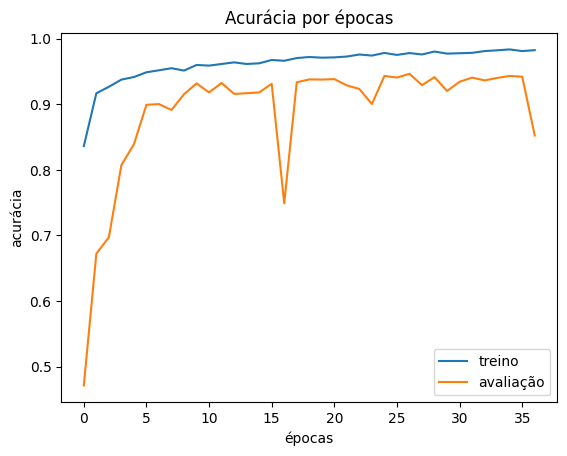

In [18]:
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'])
plt.title('Acurácia por épocas')
plt.xlabel('épocas')
plt.ylabel('acurácia')
plt.legend(['treino','avaliação'])

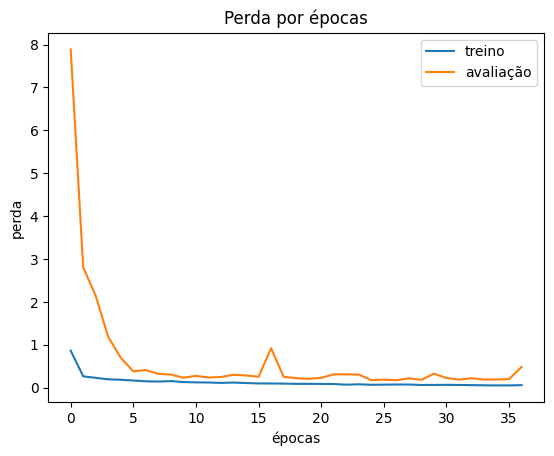

In [19]:
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('Perda por épocas')
plt.xlabel('épocas')
plt.ylabel('perda')
plt.legend(['treino','avaliação'])

In [ ]:
# Testing

used_labels_contrary = {v: k for k, v in used_labels.items()}
input_shape = model.layers[0].input_shape[1:]
# Load the true labels for the test sequence

y_true = df_test["label"].values
y_true = np.array([used_labels[i] for i in y_true])

# Get the predicted probabilities for each class
test_seq = OCTSequence(
        df_test,
        batch_size=32,
        augmentate=False,
        inputshape=input_shape,
        preprocessing_fcn=preprocessing_fcn,
    )
y_pred_prob = model.predict(test_seq)

# Get the predicted class labels
y_pred = np.argmax(y_pred_prob, axis=1)
# transform y_pred from numerical labels to string labels
y_pred_labels = [used_labels_contrary[i] for i in y_pred]
# put the predicted labels in the dataframe
df_test["predicted_label"] = y_pred_labels

In [ ]:
# Get the classification report
class_names = np.array(list(used_labels.keys()))
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

# Get the AUC for each class
auc_scores = []
for i in range(len(class_names)):
        y_true_i = (y_true == i).astype(int)
        y_pred_prob_i = y_pred_prob[:, i]
        auc_i = roc_auc_score(y_true_i, y_pred_prob_i)
        auc_scores.append(auc_i)

# Get the accuracy, sensitivity, and specificity for each class
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
for i in range(len(class_names)):
        y_true_i = (y_true == i).astype(int)
        y_pred_i = (y_pred == i).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true_i, y_pred_i).ravel()
        accuracy_i = accuracy_score(y_true_i, y_pred_i)
        sensitivity_i = tp / (tp + fn)
        specificity_i = tn / (tn + fp)
        accuracy_scores.append(accuracy_i)
        sensitivity_scores.append(sensitivity_i)
        specificity_scores.append(specificity_i)
print()

# Print the classification report, AUC scores, accuracy scores, sensitivity scores, and specificity scores
print(report)
for i in range(len(class_names)):
        print("AUC for", class_names[i], ":", auc_scores[i])
        print("Accuracy for", class_names[i], ":", accuracy_scores[i])
        print("Sensitivity for", class_names[i], ":", sensitivity_scores[i])
        print("Specificity for", class_names[i], ":", specificity_scores[i])
        print()

In [ ]:
# plot de confusion matrix

cf_matrix = confusion_matrix(y_true, y_pred)

labels = ["NORMAL", "DRUSEN", "DME", "CNV"]

plt.figure(figsize=(5, 4.5))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', cbar=True, linecolor='k',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("CONFUSION MATRIX")
plt.show()

# NORMAL: 0, DRUSEN: 1, DME: 2, CNV: 3

In [ ]:
# # resultados individuais

# df_resultado_individual = pd.DataFrame(y_pred_prob)
# df_resultado_individual = pd.DataFrame(y_pred_prob, columns=["NORMAL", "DRUSEN", "DME", "CNV"])
# df_resultado_individual = df_resultado_individual.round(3)
# df_resultado_individual.to_csv("/data/inter/modelo1_mobilenet_zhang_b32_aug.csv", index=True)

In [ ]:
# Get the accuracy, sensitivity, specificity and AUC for general
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
specificity = 1 - precision
auc = roc_auc_score(y_true, y_pred)

print("Acurácia:", accuracy)
print("Sensibilidade:", sensitivity)
print("Especificidade:", specificity)
print("AUC:", auc)